In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 25, 50, 100, 200, ] 
roc_periods = [5, 10]
multiplier = 20
bankroll = 15000
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract.loc['20180101': '20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()

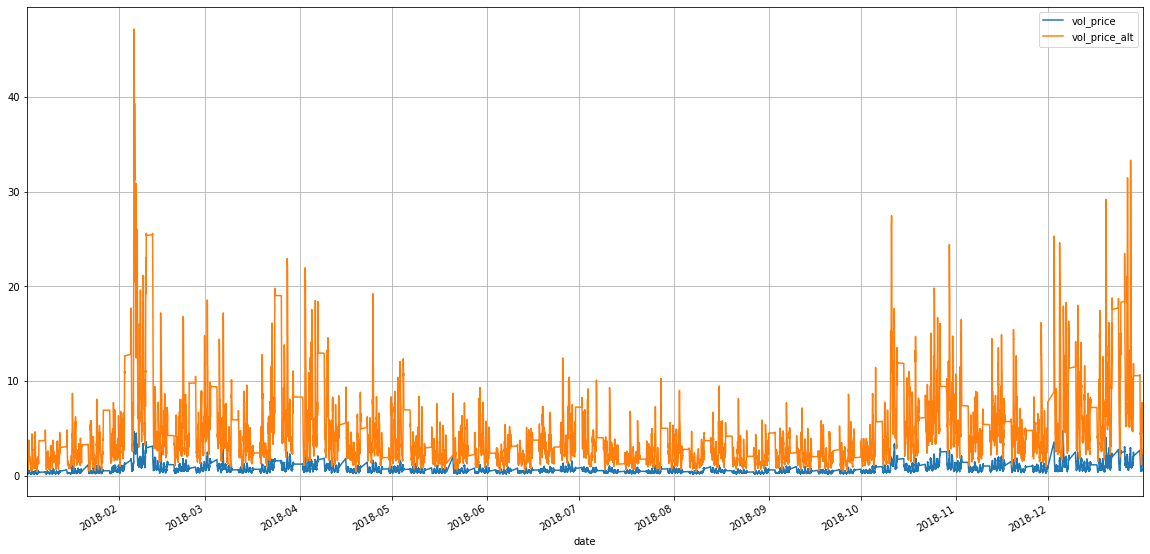

In [5]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

33236.478310851584

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 03:59:00,2675.25,2681.75,2674.50,2677.25,5890,33190,7.250000
1,2018-01-02 10:08:00,2677.25,2680.75,2676.50,2677.50,6145,33209,5.731250
2,2018-01-02 12:40:00,2677.75,2681.00,2675.25,2681.00,6026,33306,5.737657
3,2018-01-02 14:24:00,2680.75,2684.75,2680.75,2684.00,4824,33276,5.286818
4,2018-01-02 15:20:00,2684.25,2687.50,2683.75,2687.25,4230,32138,4.963897
...,...,...,...,...,...,...,...,...
10688,2018-12-31 21:58:00,2489.75,2493.50,2489.50,2493.25,4363,26034,9.453826
10689,2018-12-31 21:59:00,2493.25,2510.00,2493.00,2509.50,12168,117299,9.640151
10690,2018-12-31 22:02:00,2509.50,2513.00,2502.00,2509.25,11908,77173,9.673728


In [8]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [9]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'carver_{periods}']

In [10]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [11]:
def breakout(data, periods, smooth, *args):
    data['max'] = (data.close >= data.close.rolling(periods).max()) * 1
    data['min'] = (data.close <= data.close.rolling(periods).min()) * 1
    data[f'breakout_{periods}'] = (data['max'] - data['min']).ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [12]:
def diff(data, periods, smooth, vol):
    data = data.copy()
    data['diff'] = data.close.pct_change(periods) * 100
    data['diff_norm'] = data['diff'] / vol
    data[f'diff_{periods}'] = data['diff_norm'].ewm(span=smooth).mean()
    return data[f'diff_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [16]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema, breakout])
forecasts['diff'] = pd.DataFrame([diff(data, p, smooth, vols) for p in roc_periods]).T.mean(axis=1)

In [17]:
forecasts.tail()

,carver,ema,breakout,diff
label,,,,
10688,0.102030,0.241295,-0.019825,-0.004014
10689,0.127950,0.246868,0.020161,0.000577
10690,0.151018,0.260191,0.018611,0.006777
10691,0.173454,0.279380,0.055641,0.013321
10692,0.189210,0.300347,0.051360,0.019233


In [18]:
data = data.join(forecasts)
data = data.iloc[200:]

In [19]:
#plot(data[['close', 'carver', 'ema', 'diff']])

In [20]:
10 / data[['carver', 'ema', 'diff', 'breakout']].abs().mean()

carver       53.920680
ema           4.369438
diff        242.034348
breakout     63.832371
dtype: float64

In [21]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 20).clip(lower=-20, upper=20),
                       'breakout': (data.breakout * 80).clip(lower=-20, upper=20),
                       'ema': (data.ema * 3.5).clip(lower=-20, upper=20),
                       'diff': (data['diff'] * 624).clip(lower=-20, upper=20)
                      }
                     )

In [22]:
scaled['combined'] = scaled[['ema',  'breakout',]].mean(axis=1)

In [23]:
scaled['combined'].std()

9.207728211392608

In [24]:
10 / scaled['combined'].std() 

1.086044219640098

In [25]:
scaled['combined'] = scaled['combined'] * 1.1

In [26]:
scaled[['carver', 'ema', 'diff', 'breakout']].corr()

,carver,ema,diff,breakout
carver,1.000000,0.571289,0.799611,0.915912
ema,0.571289,1.000000,0.244056,0.396658
diff,0.799611,0.244056,1.000000,0.883240
breakout,0.915912,0.396658,0.883240,1.000000


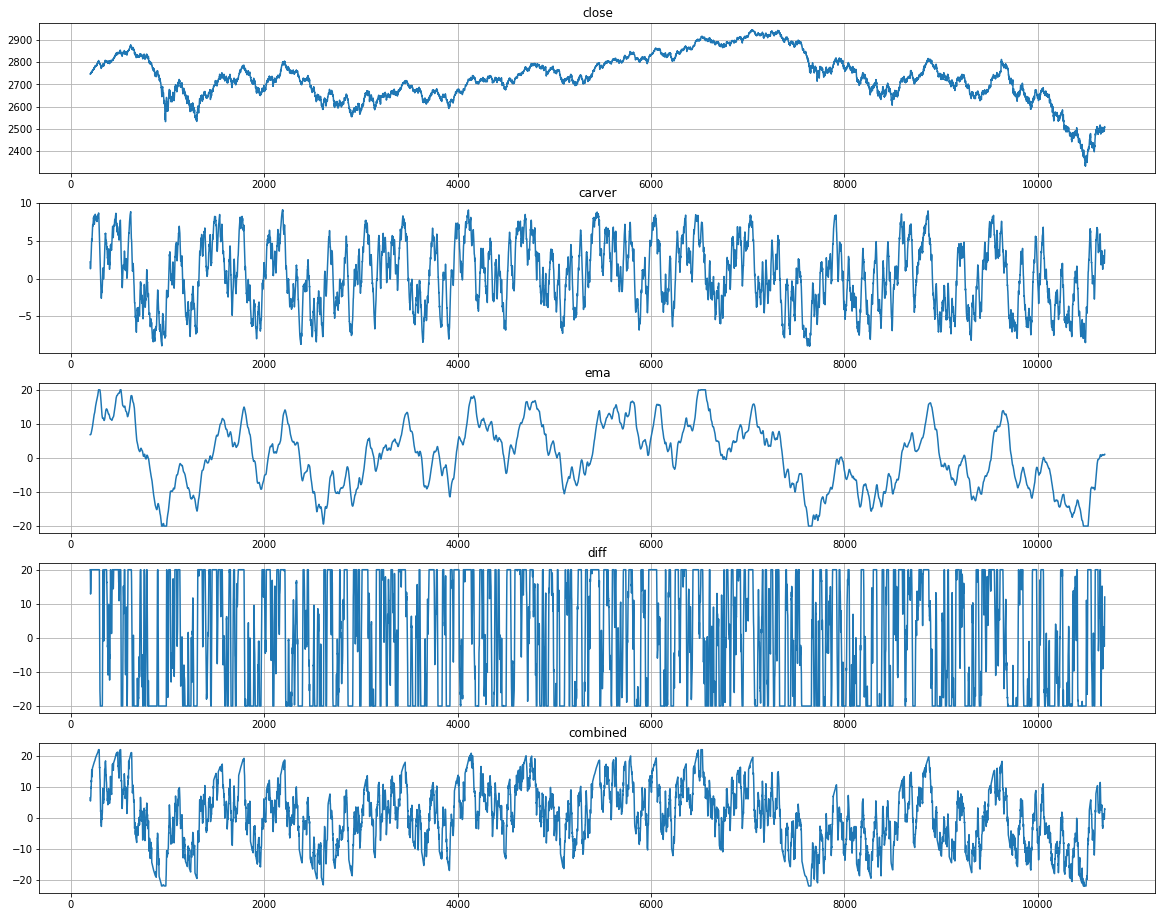

In [27]:
plot(scaled[['close', 'carver', 'ema', 'diff', 'combined']])

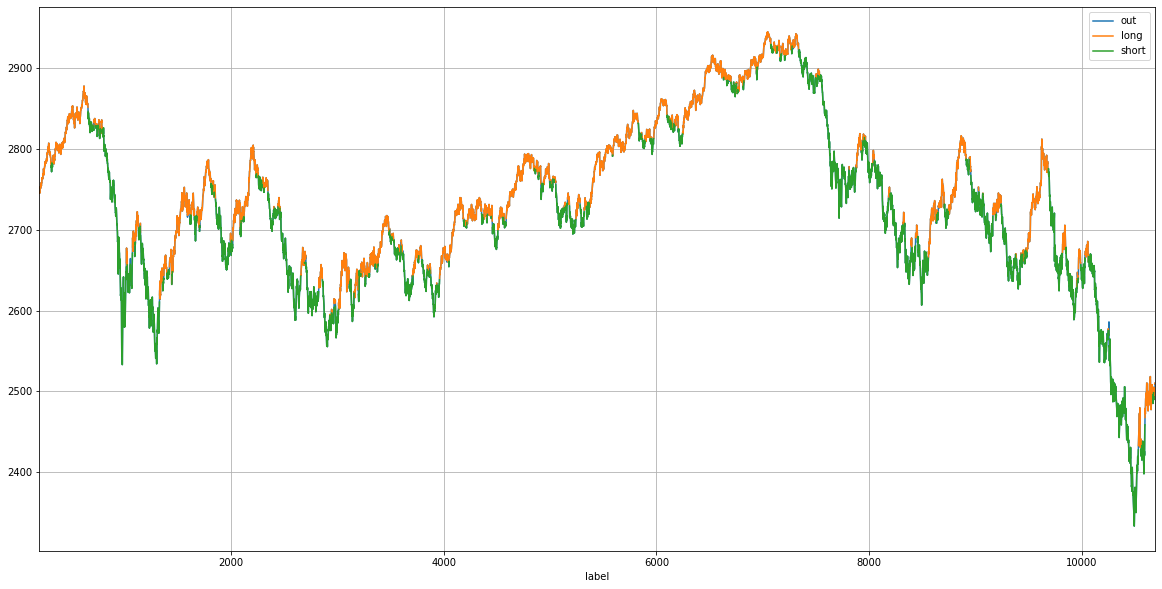

In [28]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close, scaled['combined'], 0);

In [29]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 10, ]: #12, 15, 20]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [30]:
stats

,0,1,2,3,4,5,6,7,10
Annual return,0.116228,0.143781,0.143512,0.107251,0.114612,0.109406,0.176529,0.152844,0.106353
Cumulative returns,0.11769,0.145612,0.145339,0.108595,0.116053,0.110778,0.178809,0.154798,0.107685
Annual volatility,0.156561,0.147617,0.141782,0.142116,0.135541,0.131323,0.116666,0.112754,0.0955974
Sharpe ratio,0.780015,0.983303,1.01619,0.787415,0.867814,0.855672,1.45153,1.31751,1.10458
Calmar ratio,1.13052,1.59225,1.53617,1.4923,1.75569,1.97037,4.52633,4.22986,2.03005
Stability,0.0138714,0.110737,0.113132,0.147129,0.381891,0.500793,0.686444,0.750366,0.539763
Max drawdown,-0.102809,-0.0903004,-0.0934216,-0.0718698,-0.0652803,-0.0555255,-0.0390005,-0.0361345,-0.0523896
Omega ratio,1.14727,1.19107,1.20043,1.15876,1.17786,1.17651,1.33779,1.31252,1.29495
Sortino ratio,1.23883,1.64729,1.71592,1.27802,1.44148,1.46336,2.6734,2.37995,2.0592
Skew,0.800775,1.08321,1.18646,0.909827,1.03636,1.353,1.62767,1.61184,2.5402


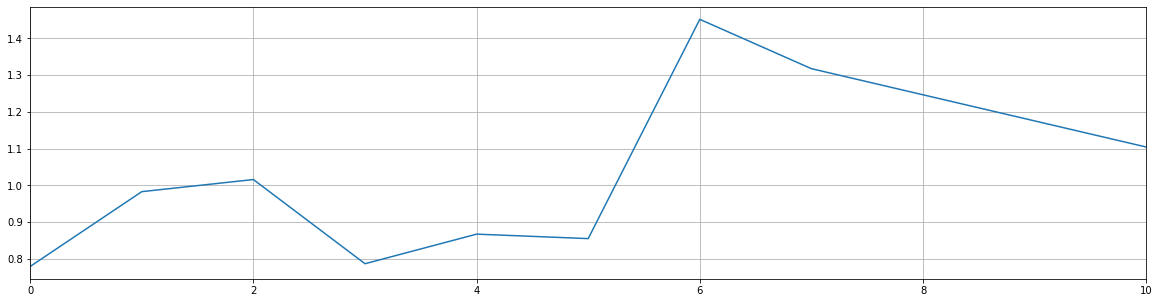

In [31]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

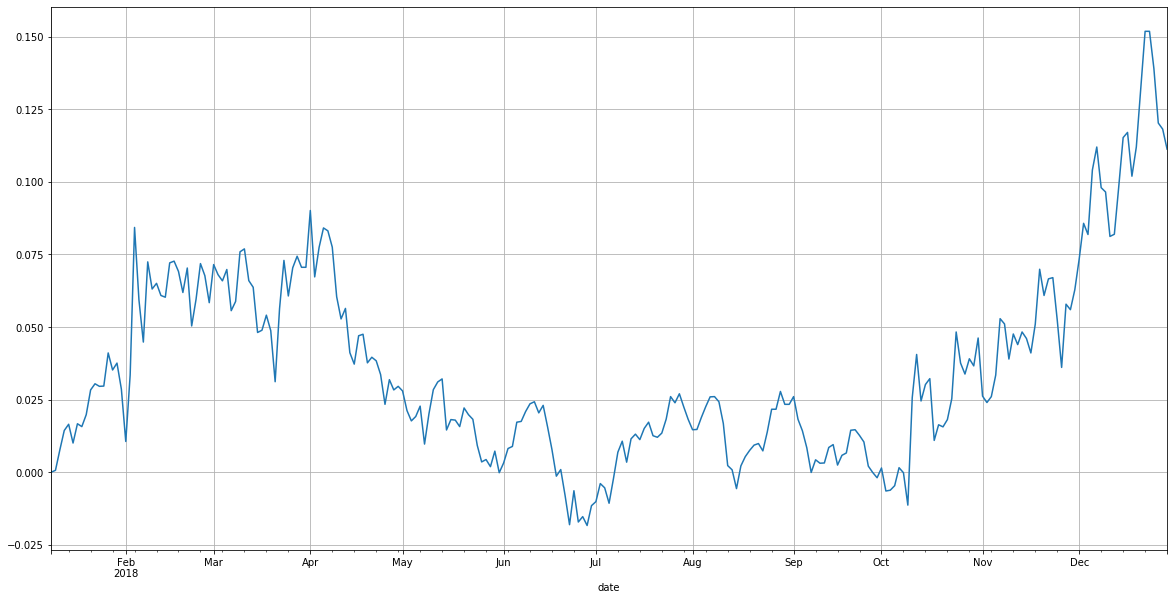

In [32]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [33]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 10, 15]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf(b, multiplier, bankroll, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [34]:
stats

,0,5,10,15
Annual return,0.425307,0.400375,0.389219,0.379703
Cumulative returns,0.431333,0.406,0.394667,0.385
Annual volatility,0.517064,0.413912,0.293841,0.228186
Sharpe ratio,0.938366,1.01452,1.26039,1.51872
Calmar ratio,1.38801,2.75244,2.72159,4.68933
Stability,0.0102484,0.507197,0.522184,0.379465
Max drawdown,-0.306416,-0.145462,-0.143012,-0.0809717
Omega ratio,1.1789,1.21479,1.35611,1.75538
Sortino ratio,1.5265,1.81604,2.49562,3.97887
Skew,0.956068,1.71331,3.27669,6.39477
